## Script permettant de lier les temps d'arrivées détectés (.arr) et la distance parcourue par le rayon détecté (eigenray, option 'E' fournissant un .ray)

In [ ]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Celerity profile selection

In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)
#s.params

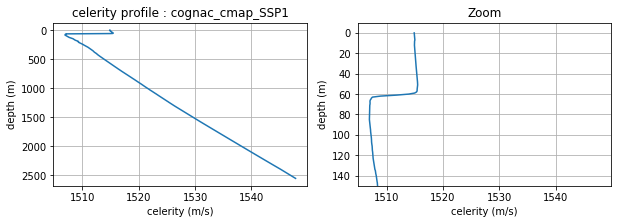

In [3]:
issp=0   # sound speed profile number
s.plotssp('mediterrannee', Issp=issp)

# Arrival calculations on this profile

- *Bathymetry* : flat bottom at 2000 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth** : from 0 to 500m depth    /    **Range** : from 0 to 10 km 

In [4]:
#Arr, Pos = s.read_arrivals_asc ('../Partie5_methode_detection/files/med1.arr', Narrmx = 2785)
Arr, Pos = s.load_dict('../Dictio', 'Arr1'), s.load_dict('../Dictio', 'Pos1')

In [5]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('number of source depths   : Nsd = ', Nsd)
print('number of receiver depths : Nrd = ', Nrd)
print('number of receiver ranges : Nrr = ', Nrr)

number of source depths   : Nsd =  1
number of receiver depths : Nrd =  501
number of receiver ranges : Nrr =  10001


# Equivalent celerity and other variables 

In [7]:
dstep = 10      # depth step (here 10m)
rstep = 100     # range step (here 1km)

In [ ]:
### Parameters to generate environnement file 
s.params['file_type'] = 'E'                  # 'E' : Eigenrays (.ray)
s.params['NDepth'] = 1                       # number of receiver depths
s.params['NRange'] = 1                       # number of receiver range   
s.params['NBeams'] = 5000 # 20000            # number of beams (if 0, bellhop choose automatically)

###SSP values
SSP_value = s.SSP['mediterrannee']['c'][issp,:]
depth = s.SSP['mediterrannee']['depth'][:]

###Sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # Bandwidth (Hz)
T = 1                    # Transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

seuil_d = 10.            # Detection treshold (dB)

###Variables
Dist_eq    = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # distance source-receiver
C_mean     = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # mean celerity source-receiver
#maximum amplitude
Tarr_A       = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # time of arrival
Dist_real_A  = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # real travelled distance
Same_nbref_A = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # same number of reflections ?
Angle_diff_A = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # diff of angle between A and E 
#detection treshold
Tarr_T       = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # time of arrival
Dist_real_T  = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # real travelled distance
Same_nbref_T = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # same number of reflections ?
Angle_diff_T = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # diff of angle between A and E 


for isd1 in range (Nsd):
    for ird1 in range (0,Nrd+1,dstep) :
        print('ird : %d/%d' %(ird1,Nrd))
        for irr1 in range (0,Nrr+1,rstep) : 
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                
                # Generate .env file E
                s.params['zmin'] = Pos['r']['depth'][ird1]          # receiver depth (m)
                s.params['rmin'] = Pos['r']['range'][irr1]/1000.    # receiver range (km)          
                s.generate_envfile('mediterrannee', file_env = s.params['name']+'_E.env', \
                                   Issp=issp, SSP_depth_step=50)
                
                # execute bellhop to obtain .ray
                subprocess.call(["bellhop.exe", s.params['name']+'_E'])
                
                # dictE from s.plotE (with plot=False)
                dictE = s.plotE (s.params['name']+'_E.ray', plot = False)
        
                # link between A and E (idx_E)
                angles_A = Arr['SrcAngle'][irr1, :Narr, ird1, isd1]
                angles_E = dictE['SrcAngle']
                #print('len anglesA : %d --- len anglesE : %d' %(len(angles_A), len(angles_E)))
                if len(angles_E) >= len(angles_A) : 
                    idx_E = np.zeros_like(angles_A)
                    Diff = np.zeros_like(angles_A)
                    for i in range (len(angles_A)):
                        angle = angles_A[i]
                        diff = np.abs(angles_E - angle)
                        idx = diff.argmin()
                        a = angles_E[idx]
                        idx_E[i] = idx
                        Diff[i] = angle - a
                    
                    ###################################################
                    
                    ## data from arrivals (A)
                    numBot_A = Arr['NumBotBnc'][irr1, :Narr, ird1, isd1]  # bottom reflections
                    numTop_A = Arr['NumTopBnc'][irr1, :Narr, ird1, isd1]  # top reflections
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]             # arrival time                  
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])            # amplitude
                    TL = - 20.0*np.log10(A)                               # transmission losss 
                    RL = SL - TL - NL +DI + PG                            # received level
                    
                    ## data from eigenrays (E)
                    d_E = dictE['Dist']                      #real distance for eigenrays (E)
                    nB_E = dictE['NumBotBnc']                #bottom reflexions for eigenrays
                    nT_E = dictE['NumTopBnc']                #top relfections for eigenrays
                    
                    ## changing from size(E) to size(A) 
                    d_real = np.zeros_like(angles_A)
                    numBot = np.zeros_like(angles_A)
                    numTop = np.zeros_like(angles_A)
                    for i in range (len(d_real)): 
                        d_real[i] = d_E[int(idx_E[i])]
                        numBot[i] = nB_E[int(idx_E[i])]
                        numTop[i] = nT_E[int(idx_E[i])]

                    
                    ################## Amplitude ######################

                    idx_max = np.where(RL==np.max(RL))
                    
                    Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = t [idx_max][0] 
                    Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = d_real [idx_max][0] 
                    Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = Diff [idx_max][0]
                
                    nB_A_max = numBot_A [idx_max][0]
                    nT_A_max = numTop_A [idx_max][0]
                    nB_E_max = numBot [idx_max][0]
                    nT_E_max = numTop [idx_max][0]
                    if np.logical_and(nB_A_max == nB_E_max, nT_A_max == nT_E_max):
                        Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = 1 

                    ################### Treshold ######################
                    
                    t_ok = t[np.where(RL > seuil_d)]                    
                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        idx_tresh = np.where(t==t_min)
          
                        Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = t [idx_tresh][0] 
                        Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = d_real [idx_tresh][0] 
                        Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = Diff [idx_tresh][0]
                    
                        nB_A_tre = numBot_A [idx_tresh][0]
                        nT_A_tre = numTop_A [idx_tresh][0]
                        nB_E_tre = numBot [idx_tresh][0]
                        nT_E_tre = numTop [idx_tresh][0]
                        if np.logical_and(nB_A_tre == nB_E_tre, nT_A_tre == nT_E_tre):
                            Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = 1 

                    else : 
                        Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        print("Pas de calculs pour detection seuil : pas de détection (arrivées<10dB)")
                        
                
                    ###################################################
                    
                else : 
                    Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    
                    Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    print("Pas de calculs : pas assez de Eigenrays")                    
                
                          
                #equivalent distance    
                sr = 0.                           # source range(m)
                sd = Pos['s']['depth'][isd1]      # source depth (m)
                rr = Pos['r']['range'][irr1]      #receiver range (m)
                rd = Pos['r']['depth'][ird1]      #receiver depth (m)
                dist_eq = np.sqrt( (rr-sr)**2 + (rd-sd)**2)
                Dist_eq [int(irr1/rstep), int(ird1/dstep), isd1] = dist_eq

                #celerity eq : mean of profile
                depth_min, depth_max = min (sd,rd), max(sd,rd)
                idx = np.where(np.logical_and(depth >=depth_min, depth<=depth_max))
                c_values = SSP_value[idx]
                C_mean [int(irr1/rstep), int(ird1/dstep), isd1] = np.mean(c_values)
                    

            else : 
                Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    
                Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                
                Dist_eq [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                C_mean [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                print("Pas de calculs : aucune arrivée")
                

# New Script : taking into account number of bounces

In [6]:
dstep = 10      # depth step (here 10m)
rstep = 100     # range step (here 1km)

In [ ]:
### Parameters to generate environnement file 
s.params['file_type'] = 'E'                  # 'E' : Eigenrays (.ray)
s.params['NDepth'] = 1                       # number of receiver depths
s.params['NRange'] = 1                       # number of receiver range   
s.params['NBeams'] = 5000 # 20000            # number of beams (if 0, bellhop choose automatically)

###SSP values
SSP_value = s.SSP['mediterrannee']['c'][issp,:]
depth = s.SSP['mediterrannee']['depth'][:]

###Sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # Bandwidth (Hz)
T = 1                    # Transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

seuil_d = 10.            # Detection treshold (dB)

###Variables
Dist_eq    = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # distance source-receiver
C_mean     = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # mean celerity source-receiver
#maximum amplitude
Tarr_A       = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # time of arrival
Dist_real_A  = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # real travelled distance
Same_nbref_A = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # same number of reflections ?
Angle_diff_A = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # diff of angle between A and E 
#detection treshold
Tarr_T       = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # time of arrival
Dist_real_T  = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # real travelled distance
Same_nbref_T = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # same number of reflections ?
Angle_diff_T = np.zeros( (int(Nrr/rstep)+1, int(Nrd/dstep)+1, Nsd) )    # diff of angle between A and E 


for isd1 in range (Nsd):
    for ird1 in range (0,Nrd+1,dstep) :
        print('ird : %d/%d' %(ird1,Nrd))
        for irr1 in range (0,Nrr+1,rstep) : 
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :

                # Generate .env file E
                s.params['zmin'] = Pos['r']['depth'][ird1]          # receiver depth (m)
                s.params['rmin'] = Pos['r']['range'][irr1]/1000.    # receiver range (km)          
                s.generate_envfile('mediterrannee', file_env = s.params['name']+'_E.env', \
                                   Issp=issp, SSP_depth_step=50)
                
                # execute bellhop to obtain .ray
                subprocess.call(["bellhop.exe", s.params['name']+'_E'])
                
                # dictE from s.plotE (with plot=False)
                dictE = s.plotE (s.params['name']+'_E.ray', plot = False)
        
                # link between A and E (idx_E)
                angles_A = Arr['SrcAngle'][irr1, :Narr, ird1, isd1]
                angles_E = dictE['SrcAngle']
                if len(angles_E) >= len(angles_A) : 
                    idx_E = np.zeros_like(angles_A)
                    Diff = np.zeros_like(angles_A)
                    for i in range (len(angles_A)):
                        angle = angles_A[i]
                        diff = np.abs(angles_E - angle)
                        
                        nB_E = dictE['NumBotBnc']     #bottom reflexions for eigenrays
                        nT_E = dictE['NumTopBnc']     #top relfections for eigenrays
                        numBot_angle = Arr['NumBotBnc'][irr1, i, ird1, isd1]
                        numTop_angle = Arr['NumTopBnc'][irr1, i, ird1, isd1]
                        
                        #idx of all angles_E with same number of bounces than angle
                        idx_same_bnc = np.where (np.logical_and(abs(diff)<3., \
                                                                np.logical_and( nB_E==numBot_angle, \
                                                                               nT_E==numTop_angle)))[0]
                        if len(idx_same_bnc) > 0 : 
                            idx = idx_same_bnc[diff[idx_same_bnc].argmin()] 
                        else :
                            # print('only same bottom bounces, and +/-1 top bounces')
                            idx_bnc = np.where (np.logical_and(abs(diff)<3., \
                                                               np.logical_and(nB_E==numBot_angle, \
                                                                              np.logical_or(nT_E==numTop_angle+1, \
                                                                                            nT_E==numTop_angle-1))))[0]
                            if len(idx_bnc) > 0 : 
                                idx = idx_bnc[diff[idx_bnc].argmin()]
                            else :
                                # print ('on prend seulement la diff la plus faible et on filtrera après)
                                idx = diff.argmin()

                        a = angles_E[idx]
                        idx_E[i] = idx
                        Diff[i] = angle - a
                    
                    ###################################################
                    
                    ## data from arrivals (A)
                    numBot_A = Arr['NumBotBnc'][irr1, :Narr, ird1, isd1]  # bottom reflections
                    numTop_A = Arr['NumTopBnc'][irr1, :Narr, ird1, isd1]  # top reflections
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]             # arrival time                  
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])            # amplitude
                    TL = - 20.0*np.log10(A)                               # transmission losss 
                    RL = SL - TL - NL +DI + PG                            # received level
                    
                    ## data from eigenrays (E)
                    d_E = dictE['Dist']                      #real distance for eigenrays (E)
                    nB_E = dictE['NumBotBnc']                #bottom reflexions for eigenrays
                    nT_E = dictE['NumTopBnc']                #top relfections for eigenrays
                    
                    ## changing from size(E) to size(A) 
                    d_real = np.zeros_like(angles_A)
                    numBot = np.zeros_like(angles_A)
                    numTop = np.zeros_like(angles_A)
                    for i in range (len(d_real)): 
                        d_real[i] = d_E[int(idx_E[i])]
                        numBot[i] = nB_E[int(idx_E[i])]
                        numTop[i] = nT_E[int(idx_E[i])]

                    
                    ################## Amplitude ######################

                    idx_max = np.where(RL==np.max(RL))
                    
                    Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = t [idx_max][0] 
                    Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = d_real [idx_max][0] 
                    Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = Diff [idx_max][0]
                
                    nB_A_max = numBot_A [idx_max][0]
                    nT_A_max = numTop_A [idx_max][0]
                    nB_E_max = numBot [idx_max][0]
                    nT_E_max = numTop [idx_max][0]
                    if np.logical_and(nB_A_max == nB_E_max, nT_A_max == nT_E_max):
                        Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = 1 

                    ################### Treshold ######################
                    
                    t_ok = t[np.where(RL > seuil_d)]                    
                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        idx_tresh = np.where(t==t_min)
          
                        Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = t [idx_tresh][0] 
                        Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = d_real [idx_tresh][0] 
                        Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = Diff [idx_tresh][0]
                    
                        nB_A_tre = numBot_A [idx_tresh][0]
                        nT_A_tre = numTop_A [idx_tresh][0]
                        nB_E_tre = numBot [idx_tresh][0]
                        nT_E_tre = numTop [idx_tresh][0]
                        if np.logical_and(nB_A_tre == nB_E_tre, nT_A_tre == nT_E_tre):
                            Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = 1 

                    else : 
                        Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                        print("Pas de calculs pour detection seuil : pas de détection (arrivées<10dB)")
                        
                
                    ###################################################
                    
                else : 
                    Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    
                    Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    print("Pas de calculs : pas assez de Eigenrays")                    
                
                          
                #equivalent distance    
                sr = 0.                           # source range(m)
                sd = Pos['s']['depth'][isd1]      # source depth (m)
                rr = Pos['r']['range'][irr1]      #receiver range (m)
                rd = Pos['r']['depth'][ird1]      #receiver depth (m)
                dist_eq = np.sqrt( (rr-sr)**2 + (rd-sd)**2)
                Dist_eq [int(irr1/rstep), int(ird1/dstep), isd1] = dist_eq

                #celerity eq : mean of profile
                depth_min, depth_max = min (sd,rd), max(sd,rd)
                idx = np.where(np.logical_and(depth >=depth_min, depth<=depth_max))
                c_values = SSP_value[idx]
                C_mean [int(irr1/rstep), int(ird1/dstep), isd1] = np.mean(c_values)
                    

            else : 
                Tarr_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Dist_real_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Angle_diff_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Same_nbref_A [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                    
                Tarr_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Dist_real_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Angle_diff_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                Same_nbref_T [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                
                Dist_eq [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                C_mean [int(irr1/rstep), int(ird1/dstep), isd1] = np.NaN
                print("Pas de calculs : aucune arrivée")

In [11]:
## saving arrays in .npy

#maximum amplitude
np.save('Tarr_A_new', Tarr_A)
np.save('Dist_real_A_new', Dist_real_A)
np.save('Angle_diff_A_new', Angle_diff_A)
np.save('Same_nbref_A_new',Same_nbref_A)

#detection treshold
np.save('Tarr_T_new', Tarr_T)
np.save('Dist_real_T_new', Dist_real_T)
np.save('Angle_diff_T_new', Angle_diff_T)
np.save('Same_nbref_T_new',Same_nbref_T)

#both 
np.save('Dist_eq_new', Dist_eq)
np.save('C_mean_new',C_mean)